## **Project: Maternal health risk prediction using machine learning**
- **Source**: Ahmed, M. et al (2020). Review and Analysis of Risk Factor of Maternal Health in Remote Area Using the Internet of Things (IoT). Conference paper InECCE2019 Lecture Notes in Electrical Engineering ((LNEE,volume 632))
- **Date**: 15/01/24
- **Goal**: Create a basic prediction model and a feature explainer


In [2]:
import pickle
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation


In [3]:
df_raw = pd.read_csv('/content/maternal_health_risk_data_set.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
df_raw.sample(10, random_state=2025)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
109,32,140,100,7.9,98.0,78,high risk
185,55,100,65,6.1,98.0,66,low risk
402,35,100,70,7.8,98.0,60,low risk
800,32,120,80,6.8,98.0,70,mid risk
684,32,140,100,6.9,98.0,78,high risk
555,50,130,100,16.0,98.0,75,mid risk
34,21,75,50,6.1,98.0,70,low risk
689,40,160,100,19.0,98.0,77,high risk
172,20,100,90,7.1,98.0,88,low risk
528,15,78,49,7.5,98.0,77,low risk


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled


In [10]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking['risklevel'] = df_baking['risklevel'].astype('category')
df_baking['heartrate'] = df_baking['heartrate'].apply(lambda x: 76 if x<50 else x)
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          1014 non-null   int64   
 1   systolicbp   1014 non-null   int64   
 2   diastolicbp  1014 non-null   int64   
 3   bs           1014 non-null   float64 
 4   bodytemp     1014 non-null   float64 
 5   heartrate    1014 non-null   int64   
 6   risklevel    1014 non-null   category
dtypes: category(1), float64(2), int64(4)
memory usage: 48.8 KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods


In [11]:
df_train, df_test = train_test_split(
    df, test_size=0.2,
    stratify=df['risklevel'], # si es clasificacion siempre se debe usar 'stratify'
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train, test_size=0.20,
    stratify=df_train['risklevel'],
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((648, 7), (163, 7), (203, 7))

In [12]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,648.0,29.859568,13.590740,10.0,19.0,25.0,37.00,66.0
systolicbp,648.0,112.958333,18.548482,70.0,98.0,120.0,120.00,160.0
diastolicbp,648.0,76.179012,13.723322,49.0,65.0,80.0,89.25,100.0
bs,648.0,8.773657,3.313049,6.0,6.9,7.5,8.00,19.0
bodytemp,648.0,98.670370,1.381301,98.0,98.0,98.0,98.00,103.0
heartrate,648.0,74.237654,7.517872,60.0,70.0,76.0,80.00,90.0


,count,unique,top,freq
risklevel,648,3,low risk,260


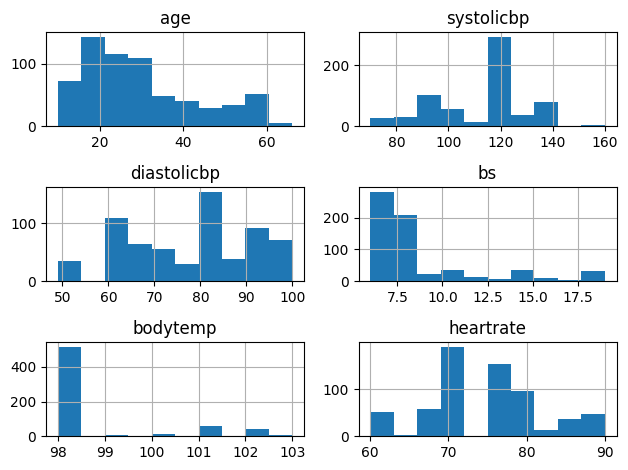

In [13]:
df_train.hist()
plt.tight_layout()
plt.show()

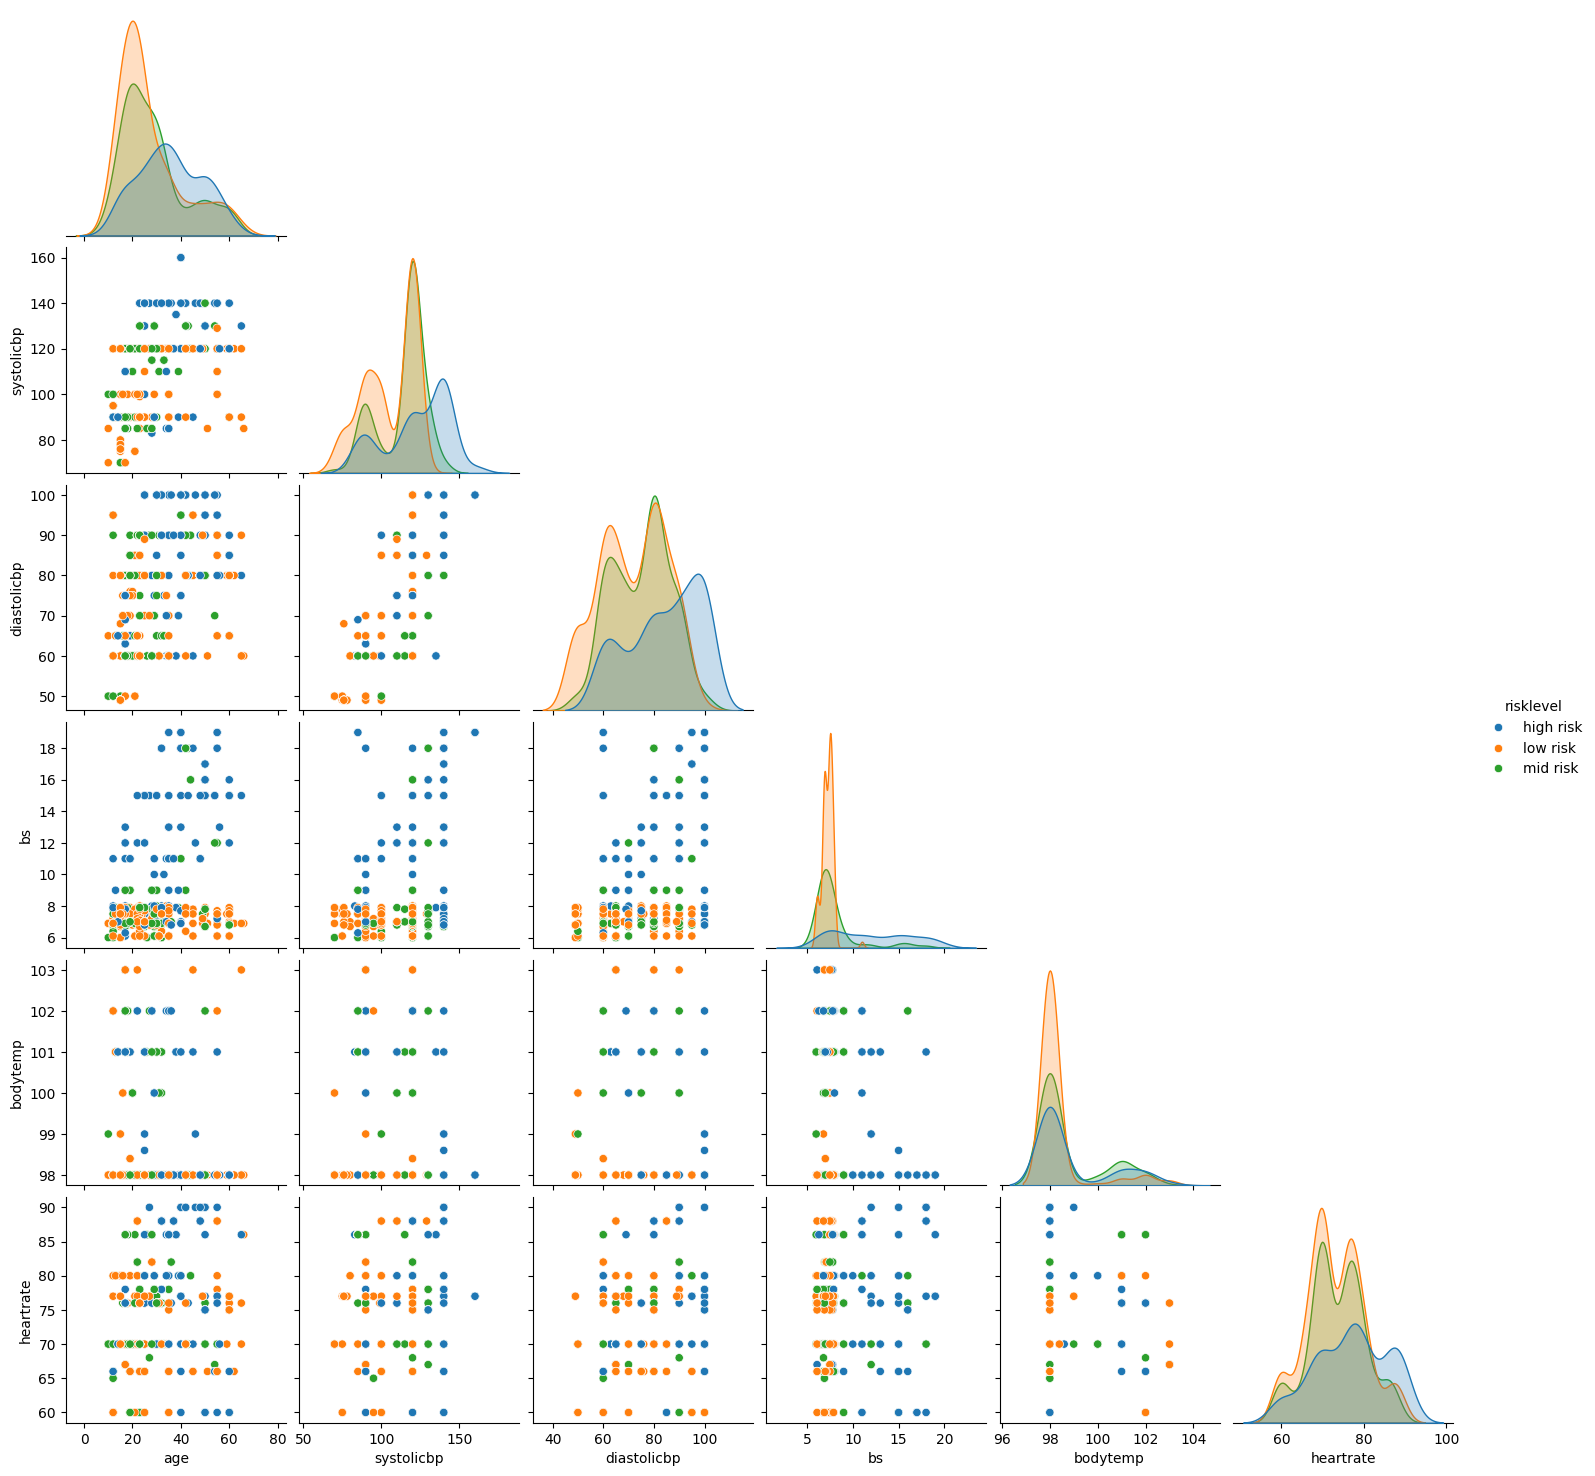

In [15]:
sns.pairplot(df_train, hue='risklevel', corner=True)
plt.show()

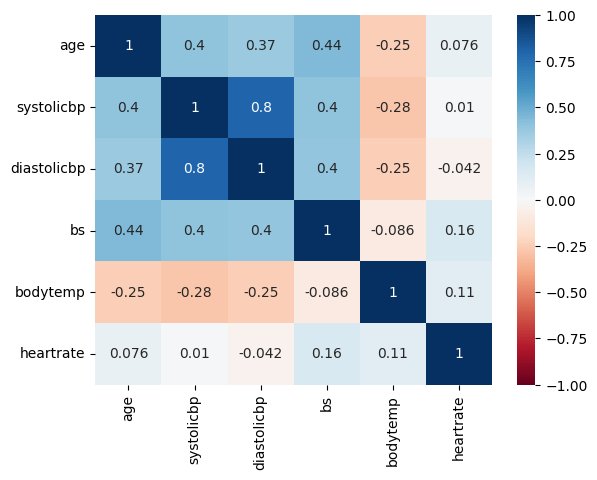

In [17]:
sns.heatmap(
    df_train.drop(columns=['risklevel']).corr(),
    vmin=-1, vmax=1, annot=True, cmap='RdBu'
)
plt.show()

### **4. Machine learning**
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [18]:
X_train = df_train.drop('risklevel', axis=1)
y_train = df_train['risklevel']
X_val = df_val.drop('risklevel', axis=1)
y_val = df_val['risklevel']
X_test = df_test.drop('risklevel', axis=1)
y_test = df_test['risklevel']

In [19]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [21]:
clf_tree_p = Pipeline([
    ('scaler', MinMaxScaler()),
    ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=2025))
])

clf_rforest_p = Pipeline([
    ('scaler', MinMaxScaler()),
    ('rforest', RandomForestClassifier(class_weight='balanced', random_state=2025))
])

clf_gboost_p = Pipeline([
    ('scaler', MinMaxScaler()),
    ('gboost', GradientBoostingClassifier(random_state=2025))
])

In [32]:
clf_tree_cv = GridSearchCV(
    clf_tree_p,
    param_grid= {
        'tree__criterion': ["gini", "entropy"],
        'tree__max_depth': [2,3,4,5,6,7,8,9,10]
    },
    cv = 10,
    scoring= 'f1_weighted',
    n_jobs=3
)
clf_tree_cv.fit(X_train, y_train_enc)
clf_tree_cv.best_params_

{'tree__criterion': 'gini', 'tree__max_depth': 10}

In [33]:
y_hat_val = clf_tree_cv.best_estimator_.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc, y_hat_val):.2f}')
print(f"f1_score: {f1_score(y_val_enc, y_hat_val, average='weighted'):.2f}")
print(f'matthews_corrcoef: {matthews_corrcoef(y_val_enc, y_hat_val):.2f}')

accuracy: 0.83
f1_score: 0.83
matthews_corrcoef: 0.74


In [35]:
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid= {
        'rforest__n_estimators': [20,40,60,80,100,150,200],
        'rforest__criterion': ["gini", "entropy"],
        'rforest__max_depth': [None,5,6,7,8,9,10]
    },
    cv= 10,
    scoring= 'f1_weighted',
    n_jobs=3
)
clf_rforest_cv.fit(X_train, y_train_enc)
clf_rforest_cv.best_params_

{'rforest__criterion': 'entropy',
 'rforest__max_depth': None,
 'rforest__n_estimators': 80}

In [36]:
y_hat_val = clf_rforest_cv.best_estimator_.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc, y_hat_val):.2f}')
print(f"f1_score: {f1_score(y_val_enc, y_hat_val, average='weighted'):.2f}")
print(f'matthews_corrcoef: {matthews_corrcoef(y_val_enc, y_hat_val):.2f}')

accuracy: 0.86
f1_score: 0.86
matthews_corrcoef: 0.79


In [38]:
clf_gboost_cv = GridSearchCV(
    clf_gboost_p,
    param_grid= {
        'gboost__learning_rate': [0.01,0.1,1],
        'gboost__n_estimators': [20,60,80,100,150],
        'gboost__max_depth': [None,5,6,7,8,9,10]
    },
    cv= 5,
    scoring= 'f1_weighted',
    n_jobs=3
)
clf_gboost_cv.fit(X_train, y_train_enc)
clf_gboost_cv.best_params_

{'gboost__learning_rate': 0.1,
 'gboost__max_depth': 6,
 'gboost__n_estimators': 60}

In [40]:
y_hat_val_gb = clf_gboost_cv.best_estimator_.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc, y_hat_val_gb):.2f}')
print(f"f1_score: {f1_score(y_val_enc, y_hat_val_gb, average='weighted'):.2f}")
print(f'matthews_corrcoef: {matthews_corrcoef(y_val_enc, y_hat_val_gb):.2f}')

accuracy: 0.84
f1_score: 0.84
matthews_corrcoef: 0.76


|model|accuracy|f1 score|matthews coef|comments|
|-----|--------|--------|-------------|--------|
|Decision tree|0.83|0.83|0.74|simplest algorithm|
|Random forest|0.86|0.86|0.79|best results|
|Gradient boosting|0.84|0.84|0.76|marginally good|

accuracy: 0.88
f1_score: 0.88
matthews_corrcoef: 0.82
              precision    recall  f1-score   support

   high risk       0.90      0.95      0.92        55
    low risk       0.87      0.93      0.90        81
    mid risk       0.88      0.78      0.83        67

    accuracy                           0.88       203
   macro avg       0.88      0.88      0.88       203
weighted avg       0.88      0.88      0.88       203



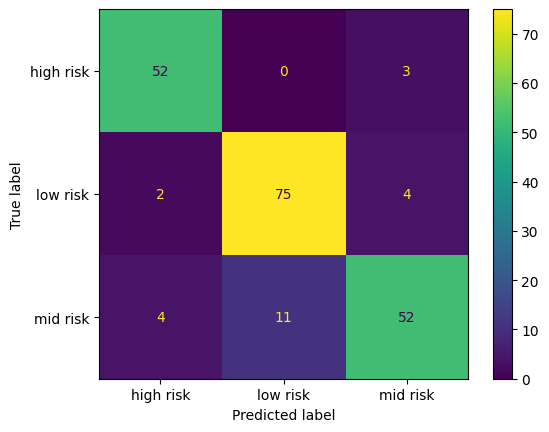

In [42]:
y_hat_test = clf_rforest_cv.best_estimator_.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc, y_hat_test):.2f}')
print(f"f1_score: {f1_score(y_test_enc, y_hat_test, average='weighted'):.2f}")
print(f'matthews_corrcoef: {matthews_corrcoef(y_test_enc, y_hat_test):.2f}')
print(classification_report(y_test_enc,y_hat_test, target_names= label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc,y_hat_test, display_labels= label_encoder.classes_)
plt.show()

### 5. **Model saving**
**Objective**: Save the model and some critical information we consider necessary

In [43]:
model_dict = {
    'model': clf_rforest_cv,
    'predictors': X_train.columns.to_list(),
    'target_names': 'risklevel',
    'target_classes': label_encoder.classes_,
    'metrics': 'accuracy: 0.88, f1: 0.88',
    'author': 'Nallely Quintero'
}

In [44]:
with open('model.pkl', 'wb') as file:
  pickle.dump(model_dict, file)

### References
[1] Heart rate - Wikipedia, retrieved on 02 Apr 2025. https://en.wikipedia.org/wiki/Heart_rate  
[2] Age and female fertility -  Wikipedia, retrieved on 02 Apr 2025. https://en.wikipedia.org/wiki/Age_and_female_fertility  
[3] Menarche - Wikipedia, retrieved on 02 Apr 2025. https://en.wikipedia.org/wiki/Menarche
